In [ ]:
#| default_exp vision_core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastMONAI.vision_plot import *
from fastai.data.all import *
from torchio import ScalarImage, LabelMap, ToCanonical, Resample

# Vision core
>

## Load images

In [ ]:
#| export
def _preprocess(obj, reorder, resample):
    """
    Preprocesses the given object.

    Args:
        obj: The object to preprocess.
        reorder: Whether to reorder the object.
        resample: Whether to resample the object.

    Returns:
        The preprocessed object and its original size.
    """
    if reorder:
        transform = ToCanonical()
        obj = transform(obj)

    original_size = obj.shape[1:]

    if resample and not all(np.isclose(obj.spacing, resample)):
        transform = Resample(resample)
        obj = transform(obj)

    if MedBase.affine_matrix is None:
        MedBase.affine_matrix = obj.affine

    return obj, original_size

In [ ]:
#| export
def _load_and_preprocess(file_path, reorder, resample, dtype):
    """
    Helper function to load and preprocess an image.

    Args:
        file_path: Image file path.
        reorder: Whether to reorder data for canonical (RAS+) orientation.
        resample: Whether to resample image to different voxel sizes and dimensions.
        dtype: Desired datatype for output.

    Returns:
        tuple: Original image, preprocessed image, and its original size.
    """
    org_img = LabelMap(file_path) if dtype is MedMask else ScalarImage(file_path) #_load(file_path, dtype=dtype) 
    input_img, org_size = _preprocess(org_img, reorder, resample)
    
    return org_img, input_img, org_size

In [ ]:
#| export
def _multi_channel(image_paths: list, reorder: bool, resample: list, dtype, only_tensor: bool):
    """
    Load and preprocess multisequence data.

    Args:
        image_paths: List of image paths (e.g., T1, T2, T1CE, DWI).
        reorder: Whether to reorder data for canonical (RAS+) orientation.
        resample: Whether to resample image to different voxel sizes and dimensions.
        dtype: Desired datatype for output.
        only_tensor: Whether to return only image tensor.

    Returns:
        torch.Tensor: A stacked 4D tensor, if `only_tensor` is True.
        tuple: Original image, preprocessed image, original size, if `only_tensor` is False.
    """
    image_data = [_load_and_preprocess(image, reorder, resample, dtype) for image in image_paths]
    org_img, input_img, org_size = image_data[-1]

    tensor = torch.stack([img.data[0] for _, img, _ in image_data], dim=0)
    
    if only_tensor: 
       return dtype(tensor) 

    input_img.set_data(tensor)
    return org_img, input_img, org_size


In [ ]:
#| export
def med_img_reader(file_path: (str, Path), dtype=torch.Tensor, reorder: bool = False,
                   resample: list = None, only_tensor: bool = True
):
    """Loads and preprocesses a medical image.

    Args:
        file_path: Path to the image. Can be a string or a Path object.
        dtype: Datatype for the return value. Defaults to torch.Tensor.
        reorder: Whether to reorder the data to be closest to canonical 
            (RAS+) orientation. Defaults to False.
        resample: Whether to resample image to different voxel sizes and 
            image dimensions. Defaults to None.
        only_tensor: Whether to return only image tensor. Defaults to True.

    Returns:
        The preprocessed image. Returns only the image tensor if 
        only_tensor is True, otherwise returns original image, 
        preprocessed image, and original size.
    """
    if isinstance(file_path, str) and ';' in file_path:
        return _multi_channel(
            file_path.split(';'), reorder, resample, dtype, only_tensor)

    org_img, input_img, org_size = _load_and_preprocess(
        file_path, reorder, resample, dtype)

    if only_tensor:
        return dtype(input_img.data.type(torch.float))

    return org_img, input_img, org_size

## Basic types -

In [ ]:
#| export
class MetaResolver(type(torch.Tensor), metaclass=BypassNewMeta):
    """
    A class to bypass metaclass conflict:
    https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/data/batch.html
    """
    pass

In [ ]:
#| export
class MedBase(torch.Tensor, metaclass=MetaResolver):
    """A class that represents an image object.
    Metaclass casts `x` to this class if it is of type `cls._bypass_type`."""
    
    _bypass_type = torch.Tensor
    _show_args = {'cmap':'gray'}
    resample, reorder = None, False
    affine_matrix = None

    @classmethod
    def create(cls, fn: (Path, str, torch.Tensor), **kwargs) -> torch.Tensor:
        """
        Opens a medical image and casts it to MedBase object.
        If `fn` is a torch.Tensor, it's cast to MedBase object.

        Args:
            fn : (Path, str, torch.Tensor)
                Image path or a 4D torch.Tensor.
            kwargs : dict
                Additional parameters for the medical image reader.

        Returns:
            torch.Tensor : A 4D tensor as a MedBase object.
        """
        if isinstance(fn, torch.Tensor):
            return cls(fn)

        return med_img_reader(fn, dtype=cls, resample=cls.resample, reorder=cls.reorder)

    @classmethod
    def item_preprocessing(cls, resample: (list, int, tuple), reorder: bool):
        """
        Changes the values for the class variables `resample` and `reorder`.

        Args:
            resample : (list, int, tuple)
                A list with voxel spacing.
            reorder : bool
                Whether to reorder the data to be closest to canonical (RAS+) orientation.
        """
        cls.resample = resample
        cls.reorder = reorder

    def show(self, ctx=None, channel: int = 0, indices: int = None, anatomical_plane: int = 0, **kwargs):
        """
        Displays the Medimage using `merge(self._show_args, kwargs)`.

        Args:
            ctx : Any, optional
                Context to use for the display. Defaults to None.
            channel : int, optional
                The channel of the image to be displayed. Defaults to 0.
            indices : list or None, optional
                Indices of the images to be displayed. Defaults to None.
            anatomical_plane : int, optional
                Anatomical plane of the image to be displayed. Defaults to 0.
            kwargs : dict, optional
                Additional parameters for the show function.

        Returns:
            Shown image.
        """
        return show_med_img(
            self, ctx=ctx, channel=channel, indices=indices, 
            anatomical_plane=anatomical_plane, voxel_size=self.resample,  
            **merge(self._show_args, kwargs)
        )

    def __repr__(self) -> str:
        """Returns the string representation of the MedBase instance."""
        return f'{self.__class__.__name__} mode={self.mode} size={"x".join([str(d) for d in self.size])}'

In [ ]:
#| export
class MedImage(MedBase):
    """Subclass of MedBase that represents an image object."""
    pass

In [ ]:
#| export
class MedMask(MedBase):
    """Subclass of MedBase that represents an mask object."""
    _show_args = {'alpha':0.5, 'cmap':'tab20'}

In [ ]:
MedBase.item_preprocessing(resample=[1,1,1], reorder=True)
im = MedImage.create('images/IXI002-Guys-0828-T1.nii.gz')
test_eq(type(im), MedImage)

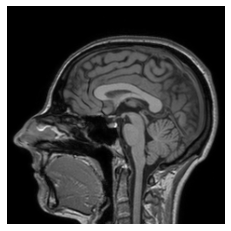

In [ ]:
ax = im.show(anatomical_plane=0)